In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set_style('whitegrid')


from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline


/tmp/ipykernel_6743/1105112844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = (df['poss'] >= 500).astype(int)
/tmp/ipykernel_6743/1105112844.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['significant_poss'] = df['significant_poss'].astype('category')


<AxesSubplot:xlabel='mp', ylabel='war_total'>

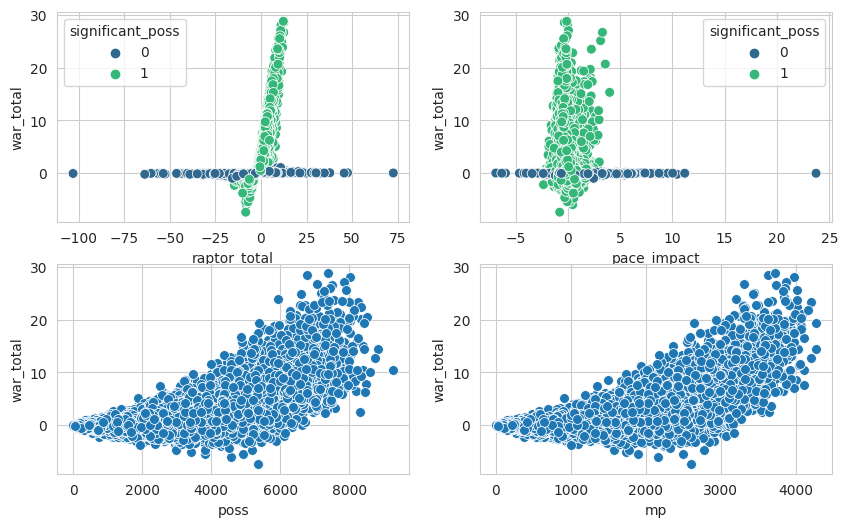

In [3]:
df_player = pd.read_csv('data/historical_RAPTOR_by_player.csv')
# I'll just keep war_total, raptor_total, pace impact. Also mp and poss
df = df_player[['player_name',	'player_id','poss',	'mp',	'raptor_total',	'war_total',	'pace_impact']]
# I will 'clusterize' by hand, dividing the data in two groups: less and more than 500 poss
df['significant_poss'] = (df['poss'] >= 500).astype(int)
# Convert 'significant_poss' to categorical type
df['significant_poss'] = df['significant_poss'].astype('category')

f,axs = plt.subplots(ncols = 2 , nrows =2 , figsize=(10, 6))
axs = axs.flatten()
sns.scatterplot(x='raptor_total', y='war_total', hue='significant_poss', palette='viridis', data=df, s=50, ax = axs[0])
sns.scatterplot(x='pace_impact' , y='war_total',hue='significant_poss', palette='viridis', data=df, s=50, ax = axs[1])
sns.scatterplot(x='poss', y='war_total',  palette='viridis', data=df, s=50, ax = axs[2])
sns.scatterplot(x='mp' , y='war_total', palette='viridis', data=df, s=50, ax = axs[3])

In [22]:
# Split the data into low possession and high possession based on your column 'significant_poss'
low_poss_df = df[df['significant_poss'] == 0]
high_poss_df = df[df['significant_poss'] == 1]

# Features (X) and target (y) for low possession
X_low = low_poss_df.sort_values('raptor_total')[[ 'raptor_total']]  # Example features
y_low = low_poss_df.sort_values('raptor_total')['war_total']  # Example target variable

# Features (X) and target (y) for high possession
X_high = high_poss_df.sort_values('raptor_total')[[ 'raptor_total']]  # Example features
y_high = high_poss_df.sort_values('raptor_total')['war_total']  # Example target variable

# Features (X) and target (y) for high possession
X_full = df.sort_values('raptor_total')[[ 'raptor_total']]  # Example features
y_full = df.sort_values('raptor_total')['war_total']  # Example target variable

In [18]:
# we'll see how well a linear model goes with raptor_total vs war_total relationship, for high and low posession,
# or without discriminating posession
# Initialize the linear regression model
linear_model = LinearRegression()
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
svr_model = SVR(kernel='rbf')

# Function to perform cross-validation and print results
def cross_validate_model(model, X, y, model_name):
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring)
    print(f"{model_name} Cross-validation RMSE Scores: {cv_results['test_neg_root_mean_squared_error']}")
    print(f"{model_name} Mean RMSE Score: {np.mean(cv_results['test_neg_root_mean_squared_error'])}")
    print(f"{model_name} Cross-validation R² Scores: {cv_results['test_r2']}")
    print(f"{model_name} Mean R² Score: {np.mean(cv_results['test_r2'])}\n")
    return cv_results



# Define the scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'r2': 'r2'
}



for model , model_name in zip([linear_model, poly_model, svr_model], ['linear_model', 'poly_model', 'svr_model']):
    for X,y,data_type  in zip([X_low,X_high,X_full],[y_low,y_high,y_full],['low','high','full']):
        cross_validate_model(model, X, y, f"{data_type} {model_name}")


low linear_model Cross-validation RMSE Scores: [-0.19004757 -0.1730085  -0.19775595 -0.19298604 -0.18675924]
low linear_model Mean RMSE Score: -0.1881114593082745
low linear_model Cross-validation R² Scores: [0.24349507 0.23007724 0.24827428 0.16818126 0.23364632]
low linear_model Mean R² Score: 0.2247348323796623

high linear_model Cross-validation RMSE Scores: [-1.71605198 -1.75298977 -1.93492438 -1.78618626 -1.59666989]
high linear_model Mean RMSE Score: -1.7573644560109027
high linear_model Cross-validation R² Scores: [0.75538744 0.78000682 0.77090156 0.77552138 0.76361951]
high linear_model Mean R² Score: 0.7690873438482112

full linear_model Cross-validation RMSE Scores: [-2.58728307 -2.68616968 -3.00545626 -2.83663305 -2.45594511]
full linear_model Mean RMSE Score: -2.7142974338885315
full linear_model Cross-validation R² Scores: [0.37940403 0.42335399 0.38523061 0.3681408  0.36600269]
full linear_model Mean R² Score: 0.38442642346606626

low poly_model Cross-validation RMSE Sco

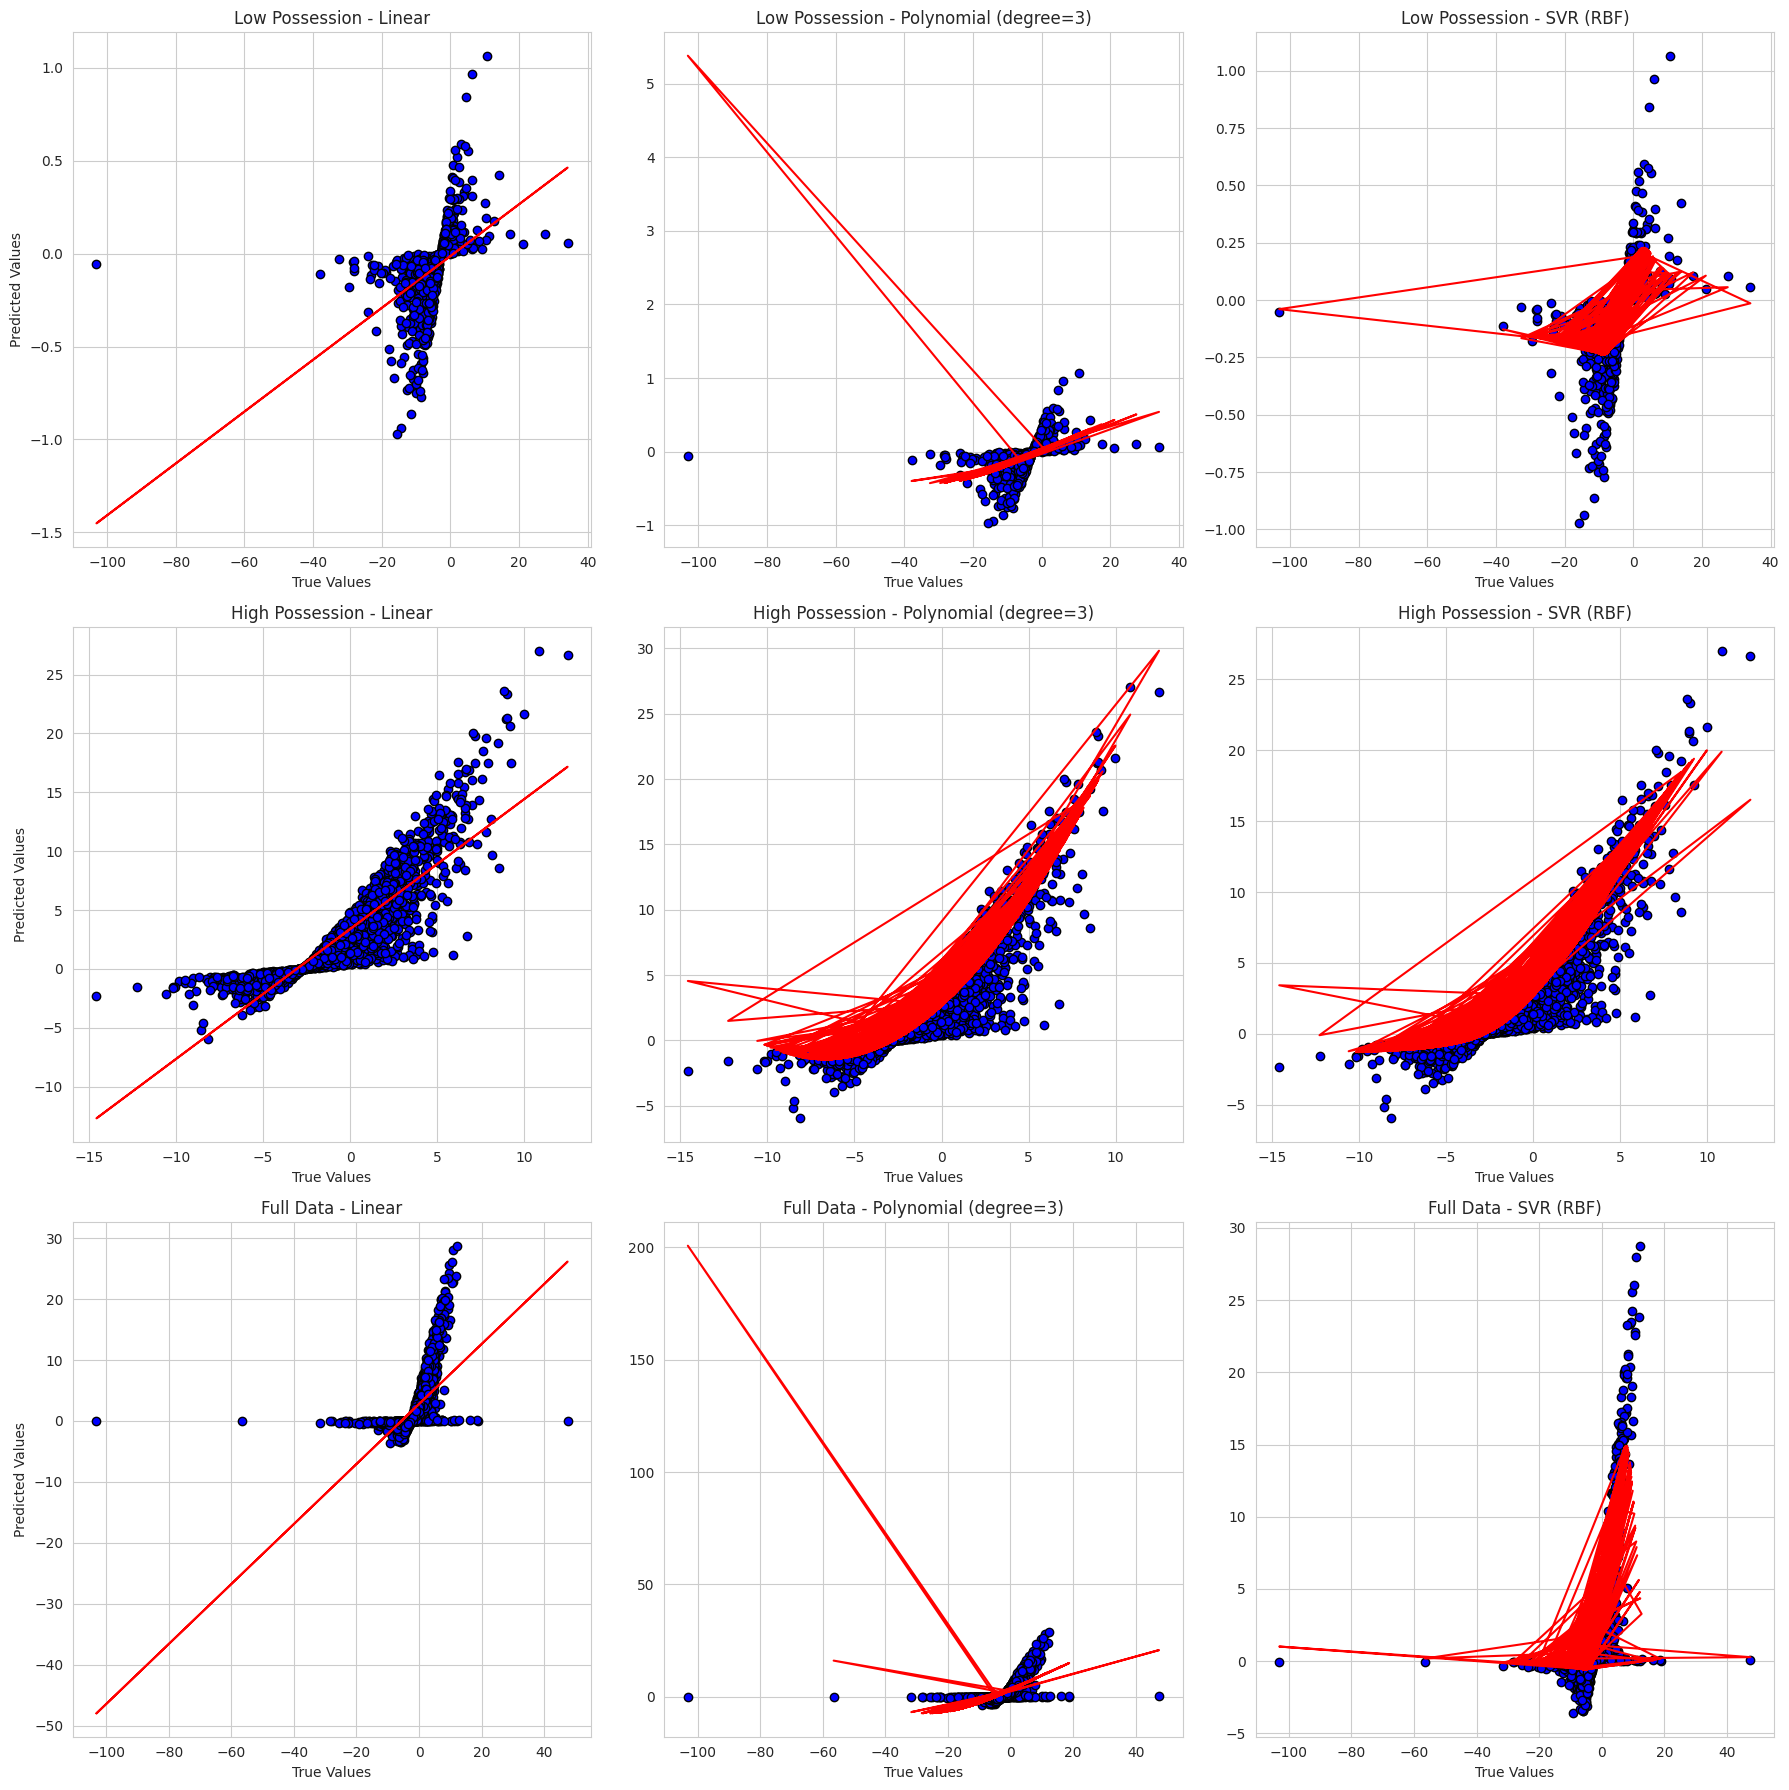

In [24]:


# Split the data into train and test for low possession
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=0.2, random_state=42)

# Split the data into train and test for high possession
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)

# Split the full data into train and test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)



# Initialize models
linear_model1 = LinearRegression()
linear_model2 = LinearRegression()
linear_model3 = LinearRegression()

poly_model1 = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model2 = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())

svr_model1 = SVR(kernel='rbf')
svr_model2 = SVR(kernel='rbf')
svr_model3 = SVR(kernel='rbf')

# Train and predict for each model on low possession data
linear_model1.fit(X_low_train, y_low_train)
y_low_pred_linear = linear_model1.predict(X_low_test)

poly_model1.fit(X_low_train, y_low_train)
y_low_pred_poly = poly_model1.predict(X_low_test)

svr_model1.fit(X_low_train, y_low_train)
y_low_pred_svr = svr_model1.predict(X_low_test)

# Train and predict for each model on high possession data
linear_model2.fit(X_high_train, y_high_train)
y_high_pred_linear = linear_model2.predict(X_high_test)

poly_model2.fit(X_high_train, y_high_train)
y_high_pred_poly = poly_model2.predict(X_high_test)

svr_model2.fit(X_high_train, y_high_train)
y_high_pred_svr = svr_model2.predict(X_high_test)

# Train and predict for each model on full data
linear_model3.fit(X_full_train, y_full_train)
y_full_pred_linear = linear_model3.predict(X_full_test)

poly_model3.fit(X_full_train, y_full_train)
y_full_pred_poly = poly_model3.predict(X_full_test)

svr_model3.fit(X_full_train, y_full_train)
y_full_pred_svr = svr_model3.predict(X_full_test)

# Plotting the results
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

# Plot for low possession
axs[0, 0].scatter(X_low_test, y_low_test, color='blue', edgecolor='k', label='data')
axs[0, 0].plot(X_low_test, y_low_pred_linear, color='red')
axs[0, 0].set_title('Low Possession - Linear')
axs[0, 0].set_xlabel('True Values')
axs[0, 0].set_ylabel('Predicted Values')

axs[0, 1].scatter(X_low_test, y_low_test, color='blue', edgecolor='k', label='data')
axs[0, 1].plot(X_low_test, y_low_pred_poly, color='red')
axs[0, 1].set_title('Low Possession - Polynomial (degree=3)')
axs[0, 1].set_xlabel('True Values')

axs[0, 2].scatter(X_low_test, y_low_test, color='blue', edgecolor='k', label='data')
axs[0, 2].plot(X_low_test, y_low_pred_svr, color='red')
axs[0, 2].set_title('Low Possession - SVR (RBF)')
axs[0, 2].set_xlabel('True Values')

# Plot for high possession
axs[1, 0].scatter(X_high_test, y_high_test, color='blue', edgecolor='k', label = 'data')
axs[1, 0].plot(X_high_test, y_high_pred_linear, color='red')
axs[1, 0].set_title('High Possession - Linear')
axs[1, 0].set_xlabel('True Values')
axs[1, 0].set_ylabel('Predicted Values')

axs[1, 1].scatter(X_high_test, y_high_test, color='blue', edgecolor='k', label = 'data')
axs[1, 1].plot(X_high_test, y_high_pred_poly, color='red')
axs[1, 1].set_title('High Possession - Polynomial (degree=3)')
axs[1, 1].set_xlabel('True Values')

axs[1, 2].scatter(X_high_test, y_high_test, color='blue', edgecolor='k', label = 'data')
axs[1, 2].plot(X_high_test, y_high_pred_svr, color='red')
axs[1, 2].set_title('High Possession - SVR (RBF)')
axs[1, 2].set_xlabel('True Values')

# Plot for full data
axs[2, 0].scatter(X_full_test, y_full_test, color='blue', edgecolor='k', label = 'data')
axs[2, 0].plot(X_full_test, y_full_pred_linear, color='red')
axs[2, 0].set_title('Full Data - Linear')
axs[2, 0].set_xlabel('True Values')
axs[2, 0].set_ylabel('Predicted Values')

axs[2, 1].scatter(X_full_test, y_full_test, color='blue', edgecolor='k', label = 'data')
axs[2, 1].plot(X_full_test, y_full_pred_poly, color='red')
axs[2, 1].set_title('Full Data - Polynomial (degree=3)')
axs[2, 1].set_xlabel('True Values')

axs[2, 2].scatter(X_full_test, y_full_test, color='blue', edgecolor='k', label = 'data')
axs[2, 2].plot(X_full_test, y_full_pred_svr, color='red')
axs[2, 2].set_title('Full Data - SVR (RBF)')
axs[2, 2].set_xlabel('True Values')

# Adjust layout
plt.tight_layout()
plt.show()
